## Librerías 

In [149]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.utils.random import sample_without_replacement
from sklearn.cluster import DBSCAN
import numpy as np
from itertools import product
import pandas as pd
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

## Dataset

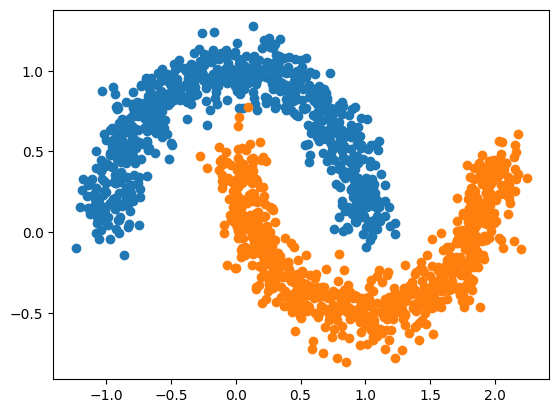

In [150]:
n_samples = 1500
noisy_moons = make_moons(n_samples=n_samples, noise=0.1, random_state=42)
X = noisy_moons[0]  # X[n_samples, 0:2]
y = noisy_moons[1]  # y[n_samples] = clases (si quiere evaluar)

all_noisy_moons = noisy_moons[0][:]

# Graficar por clases
cls0 = y == 0
cls1 = y == 1
plt.scatter(X[cls0, 0], X[cls0, 1])
plt.scatter(X[cls1, 0], X[cls1, 1])
plt.show()

## Realizamos el sampling de los datos

In [151]:
size_sample = int(len(noisy_moons[0]) * 0.1)
sample = sample_without_replacement(len(noisy_moons[0]), size_sample, random_state=42)
sample_noisy_moons = noisy_moons[0][sample]

## Visualizamos el sampleo

<function matplotlib.pyplot.show(close=None, block=None)>

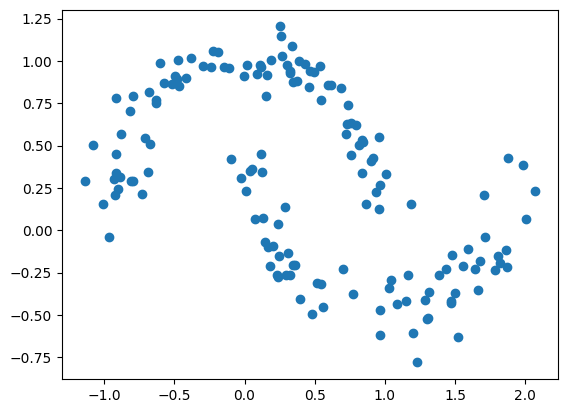

In [152]:
x_coords = sample_noisy_moons[:, 0]
y_coords = sample_noisy_moons[:, 1]
plt.scatter(x_coords, y_coords)
plt.show

### Según reposa en la documentación de sklearn los mejores algoritmos para clasificación del problema de moons son:

    -SpectralClustering
    -Ward
    -DBSCAN
    -HDBSCAN
    -OPTICS

DBSCAN demuestra ser el más eficiente en el tiempo de ejecución y puede ser una buena aproximación para el ejercicio pensado a big data.

Documentación consultada:

    -https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py
    
    -https://scikit-learn.org/stable/modules/clustering.html

#### DBSCAN

In [153]:
eps_values = np.arange(0.05, 0.5, 0.01)
min_samples_values = range(2, 10)

result = {"eps": [], "min_samples_values": [], "clusters": [], "noise points": []}

for eps, values in product(eps_values, min_samples_values):
    dbscan_model = DBSCAN(eps=eps, min_samples=values).fit(sample_noisy_moons)
    labels_dbscan = dbscan_model.labels_
    n_clusters_ = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
    n_noise_ = list(labels_dbscan).count(-1)
    result["eps"].append(eps)
    result["min_samples_values"].append(values)
    result["clusters"].append(n_clusters_)
    result["noise points"].append(n_noise_)

result_df = pd.DataFrame(result)
final_df = result_df[result_df["clusters"] == 2].loc[
    lambda df: df["noise points"] == df["noise points"].min()
]

eps = final_df["eps"].iloc[0]
min_samples_values = final_df["min_samples_values"].iloc[0]

eps1 = final_df["eps"].iloc[1]
min_samples_values1 = final_df["min_samples_values"].iloc[1]

eps2 = final_df["eps"].iloc[2]
min_samples_values2 = final_df["min_samples_values"].iloc[2]

final_df.head()

,eps,min_samples_values,clusters,noise points
160,0.25,2,2,0
161,0.25,3,2,0
168,0.26,2,2,0
169,0.26,3,2,0
176,0.27,2,2,0


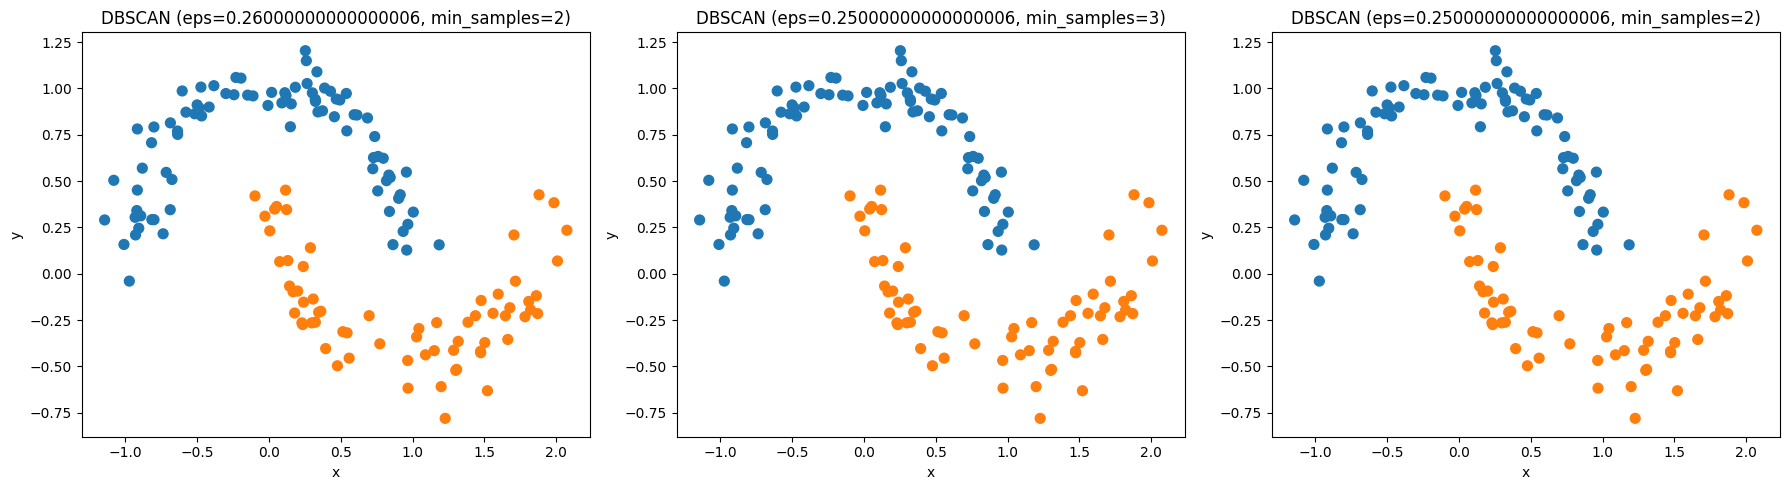

In [154]:
custom_cmap = ListedColormap(["#1f77b4", "#ff7f0e"])  # Azul y naranja

dbscan_params = [
    {"eps": eps2, "min_samples": min_samples_values2},
    {"eps": eps1, "min_samples": min_samples_values1},
    {"eps": eps, "min_samples": min_samples_values},
]

# Crear una figura con subplots en una sola fila
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Iterar sobre las configuraciones y generar los subplots
for ax, params in zip(axes, dbscan_params):
    dbscan = DBSCAN(eps=params["eps"], min_samples=params["min_samples"])
    labels_dbscan = dbscan.fit_predict(sample_noisy_moons)

    scatter = ax.scatter(
        sample_noisy_moons[:, 0],
        sample_noisy_moons[:, 1],
        c=labels_dbscan,
        cmap=custom_cmap,
        s=50,
    )
    ax.set_title(f"DBSCAN (eps={params['eps']}, min_samples={params['min_samples']})")
    ax.set_xlabel("x")
    ax.set_ylabel("y")

plt.tight_layout()
plt.show()

## Ubicación del centroide

In [155]:
points_label_0 = sample_noisy_moons[labels_dbscan == 0]
points_label_1 = sample_noisy_moons[labels_dbscan == 1]
centroid_0 = np.median(points_label_0[:, 0]), np.median(points_label_0[:, 1])
centroid_1 = np.median(points_label_1[:, 0]), np.median(points_label_1[:, 1])

## Ubicación de puntos más alejados del centroide

In [156]:
def select_distant_points(points, fraction=0.5):
    """Select points starting from the centroid, choosing subsequent points based on max distance from the already selected points."""
    if points.size == 0:
        return np.array([])  # Return an empty array if there are no points

    centroid = np.mean(points, axis=0)
    selected_points = [centroid]
    num_points = min(int(len(points) * fraction), len(points))

    for _ in range(num_points - 1):
        distances = np.min(
            np.sqrt((points[:, np.newaxis] - np.array(selected_points)) ** 2).sum(
                axis=2
            ),
            axis=1,
        )
        max_index = np.argmax(distances)
        selected_points.append(points[max_index])
        points = np.delete(points, max_index, axis=0)

    return np.array(selected_points)


# Assume sample_noisy_moons and labels_dbscan are defined
points_label_0 = sample_noisy_moons[labels_dbscan == 0]
selected_points_0 = select_distant_points(points_label_0)

points_label_1 = sample_noisy_moons[labels_dbscan == 1]
selected_points_1 = select_distant_points(points_label_1)

Text(0.5, 1.0, 'DBSCAN Clustering with Additional Points')

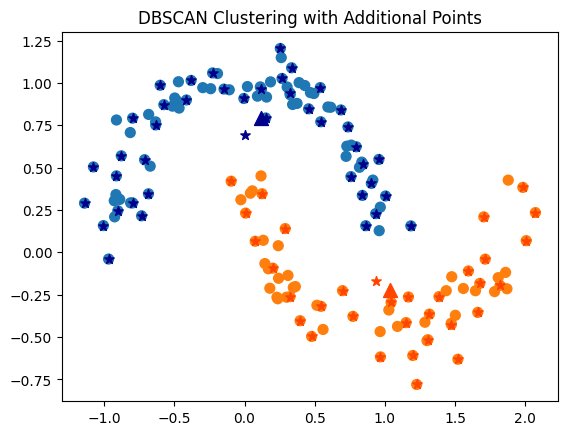

In [157]:
# Plotting the DBSCAN results
plt.scatter(
    sample_noisy_moons[:, 0],
    sample_noisy_moons[:, 1],
    c=labels_dbscan,
    cmap=custom_cmap,
    s=50,
    label="Clustered Data",
)
plt.scatter(
    centroid_0[0],
    centroid_0[1],
    marker="^",
    s=100,
    color="darkblue",
    label="Centroid of Label 0",
)
plt.scatter(
    centroid_1[0],
    centroid_1[1],
    marker="^",
    s=100,
    color="orangered",
    label="Centroid of Label 1",
)

# Assume 'selected_points' contains the 50 points with max distance found iteratively
# This should be defined from the previous section of code
if selected_points_0.shape[0] > 0:
    plt.scatter(
        selected_points_0[:, 0],
        selected_points_0[:, 1],
        marker="*",
        s=50,
        color="darkblue",
        label="Selected Points",
    )
# This should be defined from the previous section of code
if selected_points_1.shape[0] > 0:
    plt.scatter(
        selected_points_1[:, 0],
        selected_points_1[:, 1],
        marker="*",
        s=50,
        color="orangered",
        label="Selected Points",
    )


plt.title("DBSCAN Clustering with Additional Points")

## Creación de puntos sinteticos

In [158]:
def move_points_closer(points, centroid, alpha):
    """Move each point in 'points' alpha percent closer to 'centroid'."""
    return centroid + (points - centroid) * (1 - alpha)


alpha = 0.20

adjusted_points_0 = move_points_closer(
    selected_points_0, np.mean(selected_points_0, axis=0), alpha
)
adjusted_points_1 = move_points_closer(
    selected_points_1, np.mean(selected_points_1, axis=0), alpha
)

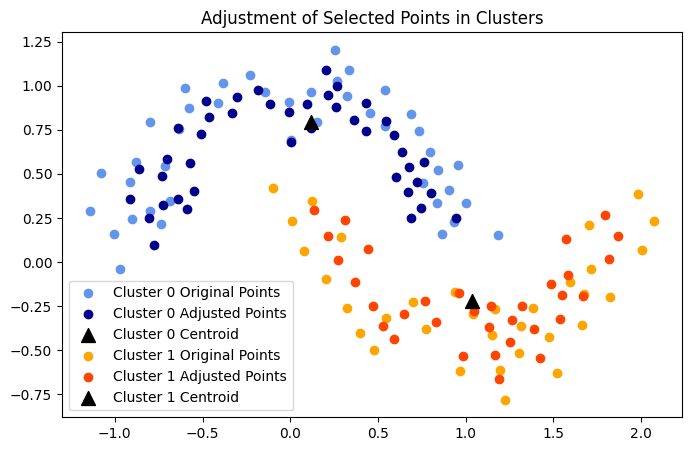

In [159]:
def plot_cluster_adjustments(
    points_original,
    points_adjusted,
    centroid,
    original_color,
    adjusted_color,
    label_prefix,
):
    plt.scatter(
        points_original[:, 0],
        points_original[:, 1],
        color=original_color,
        label=f"{label_prefix} Original Points",
    )
    plt.scatter(
        points_adjusted[:, 0],
        points_adjusted[:, 1],
        color=adjusted_color,
        label=f"{label_prefix} Adjusted Points",
    )
    plt.scatter(
        centroid[0],
        centroid[1],
        marker="^",
        s=100,
        color="black",
        label=f"{label_prefix} Centroid",
    )


plt.figure(figsize=(8, 5))

# Plot adjustments for Cluster 0
plot_cluster_adjustments(
    selected_points_0,
    adjusted_points_0,
    centroid_0,
    "cornflowerblue",
    "darkblue",
    "Cluster 0",
)

# Plot adjustments for Cluster 1
plot_cluster_adjustments(
    selected_points_1,
    adjusted_points_1,
    centroid_1,
    "orange",
    "orangered",
    "Cluster 1",
)

plt.title("Adjustment of Selected Points in Clusters")
plt.legend()
plt.show()

## Ubicación de los puntos del dataset

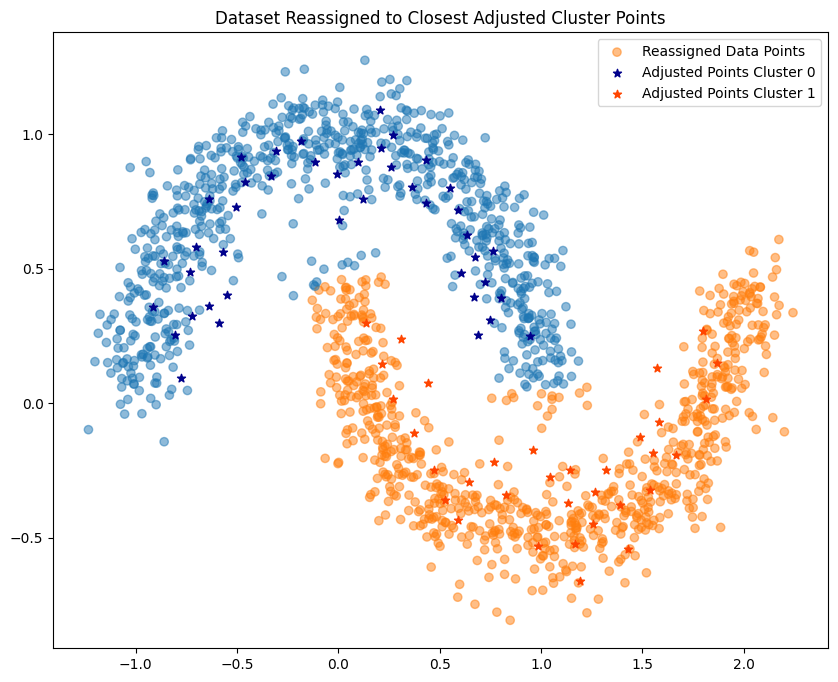

In [160]:
def assign_cluster_based_on_min_distance(data_points, cluster0_points, cluster1_points):
    # Calculate distances to the adjusted points of cluster 0
    dist_to_cluster0 = np.sqrt(
        ((data_points[:, np.newaxis] - cluster0_points) ** 2).sum(axis=2)
    )
    min_dist_to_cluster0 = np.min(dist_to_cluster0, axis=1)

    # Calculate distances to the adjusted points of cluster 1
    dist_to_cluster1 = np.sqrt(
        ((data_points[:, np.newaxis] - cluster1_points) ** 2).sum(axis=2)
    )
    min_dist_to_cluster1 = np.min(dist_to_cluster1, axis=1)

    # Assign labels based on the minimum distance
    labels = np.where(min_dist_to_cluster0 < min_dist_to_cluster1, 0, 1)
    return labels


# Assuming adjusted_points_0 and adjusted_points_1 are already defined
new_labels = assign_cluster_based_on_min_distance(
    all_noisy_moons, adjusted_points_0, adjusted_points_1
)

# Plotting the reassigned dataset
plt.figure(figsize=(10, 8))
plt.scatter(
    all_noisy_moons[:, 0],
    all_noisy_moons[:, 1],
    c=new_labels,
    cmap=custom_cmap,
    alpha=0.5,
    label="Reassigned Data Points",
)
plt.scatter(
    adjusted_points_0[:, 0],
    adjusted_points_0[:, 1],
    color="darkblue",
    marker="*",
    label="Adjusted Points Cluster 0",
)
plt.scatter(
    adjusted_points_1[:, 0],
    adjusted_points_1[:, 1],
    color="orangered",
    marker="*",
    label="Adjusted Points Cluster 1",
)
plt.title("Dataset Reassigned to Closest Adjusted Cluster Points")
plt.legend()
plt.show()

## Accuracy

In [161]:
true_labels = noisy_moons[1]
accuracy = accuracy_score(true_labels, new_labels)
print(accuracy)

0.98


## Ajuste del Alpha a 0.15

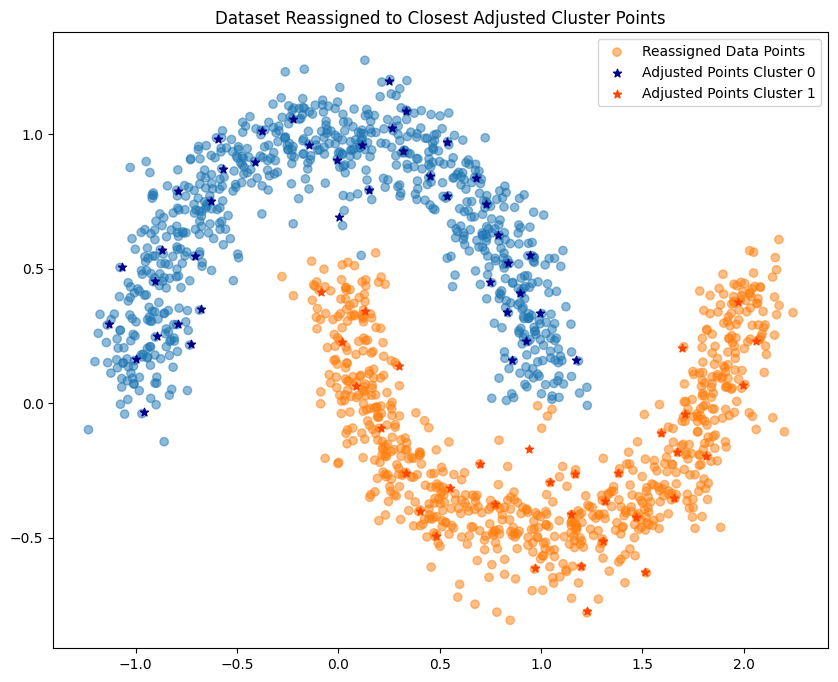

In [170]:
alpha = 0.01

adjusted_points_0 = move_points_closer(
    selected_points_0, np.mean(selected_points_0, axis=0), alpha
)
adjusted_points_1 = move_points_closer(
    selected_points_1, np.mean(selected_points_1, axis=0), alpha
)

# Assuming adjusted_points_0 and adjusted_points_1 are already defined
new_labels = assign_cluster_based_on_min_distance(
    all_noisy_moons, adjusted_points_0, adjusted_points_1
)

# Plotting the reassigned dataset
plt.figure(figsize=(10, 8))
plt.scatter(
    all_noisy_moons[:, 0],
    all_noisy_moons[:, 1],
    c=new_labels,
    cmap=custom_cmap,
    alpha=0.5,
    label="Reassigned Data Points",
)
plt.scatter(
    adjusted_points_0[:, 0],
    adjusted_points_0[:, 1],
    color="darkblue",
    marker="*",
    label="Adjusted Points Cluster 0",
)
plt.scatter(
    adjusted_points_1[:, 0],
    adjusted_points_1[:, 1],
    color="orangered",
    marker="*",
    label="Adjusted Points Cluster 1",
)
plt.title("Dataset Reassigned to Closest Adjusted Cluster Points")
plt.legend()
plt.show()

## Accuracy

In [171]:
true_labels = noisy_moons[1]
accuracy = accuracy_score(true_labels, new_labels)
print(accuracy)

0.9946666666666667
